# **Classifying Colon Histopathology Images Using Machine Learning**

Names: Vonny Nguyen,
Student IDs: s3992230,

### Problem Statement:
Colorectal cancer is one of the most prevalent cancers globally, and early detection is critical for improving treatment outcomes. However, manual diagnosis of colon histopathology images is labor-intensive, time-consuming, and subject to inter-observer variability. The goal of this project is to design and evaluate a machine learning system that can assist in diagnosing colon cancer by analyzing histopathology images of individual cells.

The system is designed to perform two key tasks:
- Binary classification – determine whether a given cell is cancerous or not.
- Multi-class classification – identify the cell type as fibroblast, inflammatory, epithelial, or other.

An accurate automated model would support pathologists by improving consistency, reducing diagnostic workload, and potentially accelerating decision-making in clinical workflows. Throughout the project, various preprocessing techniques and machine learning models will be explored, evaluated, and compared to select the most effective approach for both classification tasks.

### Dataset Overview: 
The dataset consists of 27x27-pixel color images of colon cells collected from 99 patients, divided into two labeled subsets:
- mainData.csv: contains full labels (cancer status and cell type) for 60 patients.
- extraData.csv: contains partial labels (cancer status only) for 39 additional patients.

Each image is an RGB image with a corresponding cancer label (isCancerous: 0 or 1) and, where available, a cell type label (cellTypeName: fibroblast, inflammatory, epithelial, other). Due to the small image size, high intra-class similarity, and significant class imbalance (e.g., far fewer cancerous images than non-cancerous), this dataset presents several challenges. These characteristics make it well-suited for experimenting with image-specific machine learning approaches, particularly convolutional neural networks (CNNs).

### Goals:
This project aims to:
- Build a reliable binary classifier for detecting cancerous cells.
- Develop a multi-class classifier to label cells by their biological type.
- Compare the performance of various machine learning models and preprocessing strategies.
- Use well-justified evaluation metrics beyond simple accuracy (e.g., recall, F1-score) to ensure meaningful results, particularly for imbalanced classes.
- Benchmark the final models against prior approaches in the literature, where possible, to assess effectiveness.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from zipfile import ZipFile
import cv2

In [2]:
with ZipFile(r'Machine-Learning\Image_classification_data.zip', 'r') as zipobj:
    zipobj.extractall('colon_data')

In [3]:
image_dir = 'colon_data'
print(os.listdir(image_dir))

['data_labels_extraData.csv', 'data_labels_mainData.csv', 'patch_images', '__MACOSX']


In [4]:
#Loading CSV
df2 = pd.read_csv('colon_data/data_labels_mainData.csv')
df1 = pd.read_csv('colon_data/data_labels_extraData.csv')

In [5]:
df2.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [6]:
df1.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


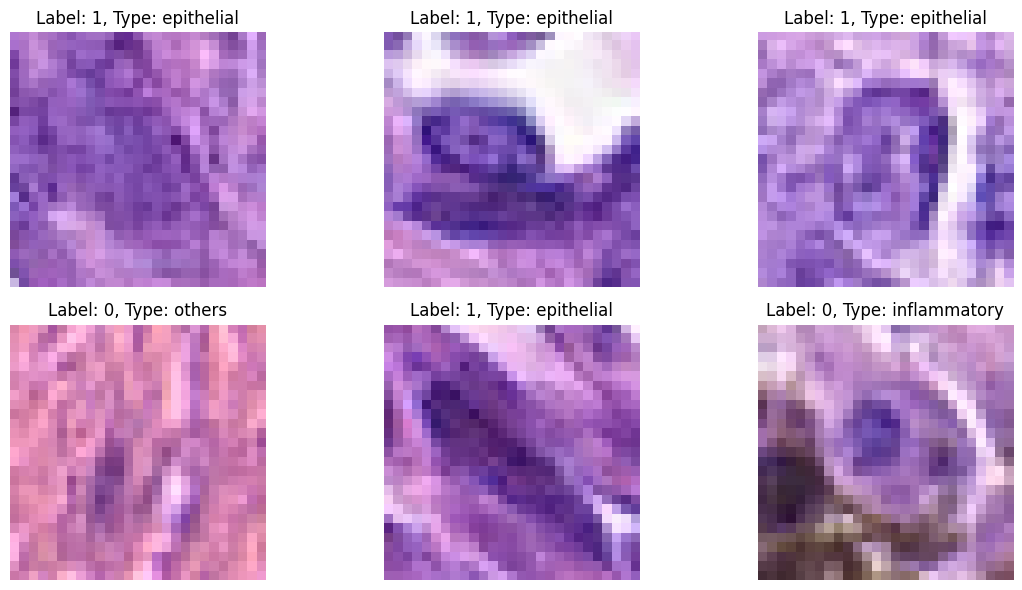

In [7]:
image_dir = 'colon_data/patch_images'

def display_sample_images(df, num_samples=6):
    sample_df = df.sample(n=num_samples)
    plt.figure(figsize=(12, 6))

    for i, (_, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(image_dir, row['ImageName'])
        img = Image.open(img_path)
 
        # Dynamically build the title
        title = f"Label: {row['isCancerous']}"
        if 'cellTypeName' in row:
            title += f", Type: {row['cellTypeName']}"

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Display samples from main_df(df2)
display_sample_images(df2)

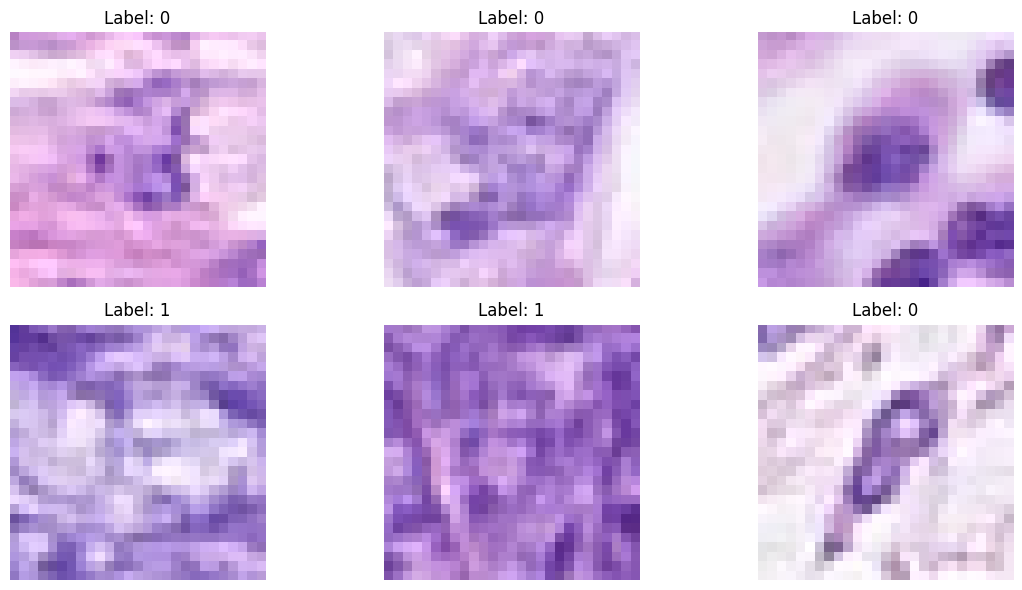

In [8]:
display_sample_images(df1)

# Exploratory Data Analysis
To understand the data characteristics before training any models, we conducted several visual and statistical analyses. The key findings are summarized below.

# Relationship Between Cell Type and Cancer Status

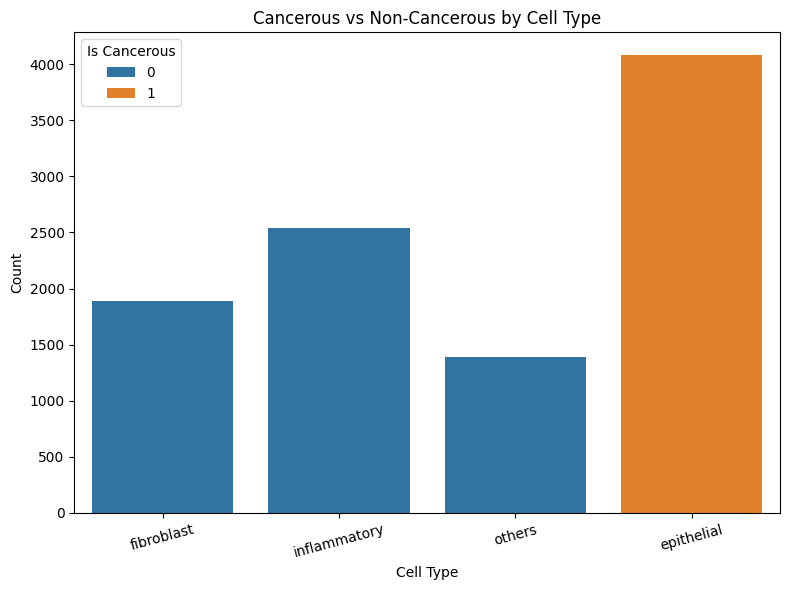

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='cellTypeName', hue='isCancerous', data=df2)
plt.title('Cancerous vs Non-Cancerous by Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='Is Cancerous')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Key Insights
A grouped bar chart was plotted to show the distribution of cancerous (isCancerous = 1) and non-cancerous (isCancerous = 0) cells across different cell types. The most notable insights include:
- Epithelial cells are almost exclusively labeled as cancerous, suggesting a strong biological link between this cell type and cancer presence.
- In contrast, fibroblast, inflammatory, and other cell types are predominantly non-cancerous.

Implication: This strong correlation between cell type and cancer label may influence the learning process of the classification models. In multi-task or joint classification models, such dependency might introduce bias or lead to feature leakage if not handled carefully.

# Distribution of Cancer labels in Main vs Extra Data

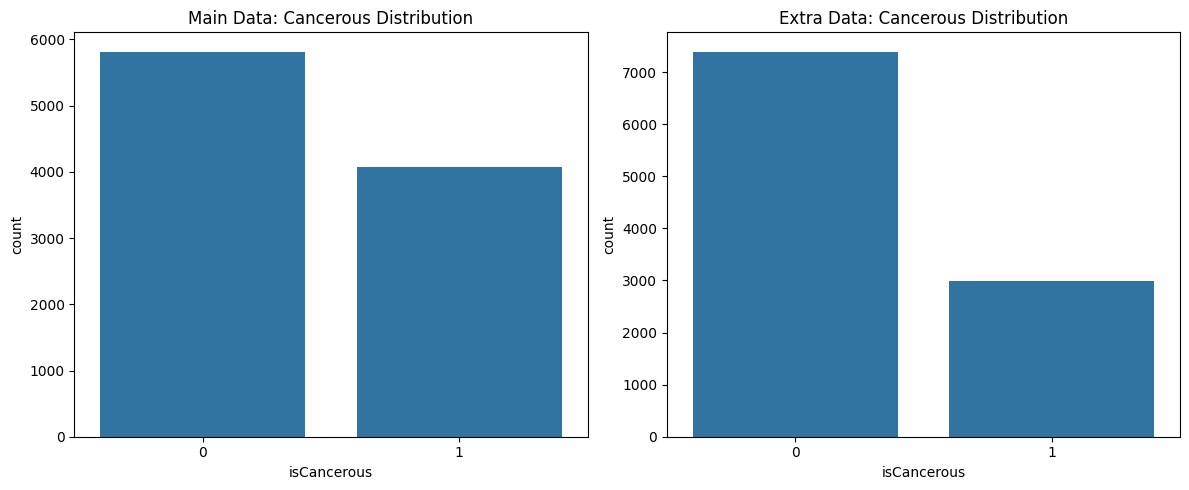

In [10]:
# Check cancerous label distribution in main and extra data
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='isCancerous', data=df2, ax=axs[0])
axs[0].set_title('Main Data: Cancerous Distribution')

sns.countplot(x='isCancerous', data=df1, ax=axs[1])
axs[1].set_title('Extra Data: Cancerous Distribution')

plt.tight_layout()
plt.show()

### Observations
To inspect potential class imbalances, we visualized the cancer label distribution separately for both datasets:
- Main dataset: More non-cancerous samples than cancerous ones.
- Extra dataset: Shows a similar imbalance, reinforcing that cancerous cases are underrepresented overall.

Implication: The skewed label distribution may bias classifiers toward predicting the majority class (non-cancerous). In medical contexts, this is particularly dangerous as false negatives (failing to identify cancer) can have serious consequences. This necessitates the use of imbalance-handling strategies like data augmentation or class weighting during training.

# Missing Values Check

In [15]:
print("Missing values in df2:")
print(df2.isnull().sum())

print("\nMissing values in df1:")
print(df1.isnull().sum())

Missing values in df2:
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

Missing values in df1:
InstanceID     0
patientID      0
ImageName      0
isCancerous    0
dtype: int64


### Result:
We verified the presence of null or missing values in both df1 and df2:
- Result: No missing values were detected in either dataset.

Implication: Since all samples are complete, we avoid the need for imputation or sample removal, simplifying preprocessing and ensuring data integrity.

# Image Shape and Channel Analysis

100%|██████████| 9896/9896 [01:11<00:00, 138.99it/s]


        Width  Height  Channels
count  9896.0  9896.0    9896.0
mean     27.0    27.0       3.0
std       0.0     0.0       0.0
min      27.0    27.0       3.0
25%      27.0    27.0       3.0
50%      27.0    27.0       3.0
75%      27.0    27.0       3.0
max      27.0    27.0       3.0


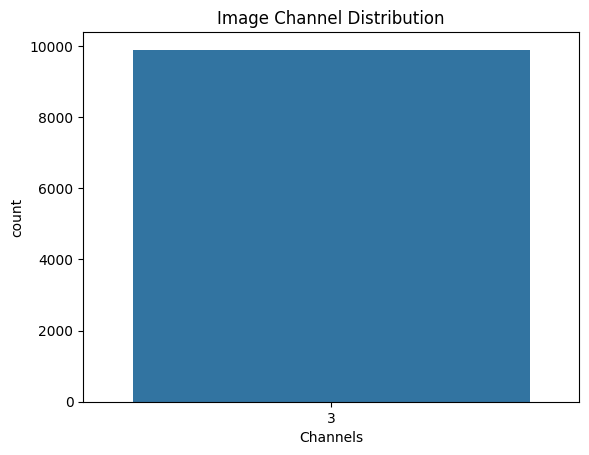

In [12]:
from tqdm import tqdm

def get_image_shapes(df):
    shapes = []
    for img_name in tqdm(df['ImageName']):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path)
        shapes.append(img.size + (len(img.getbands()),))  # (width, height, channels)
    return shapes

shapes_main = get_image_shapes(df2)
shapes_df = pd.DataFrame(shapes_main, columns=['Width', 'Height', 'Channels'])
print(shapes_df.describe())

sns.countplot(x='Channels', data=shapes_df)
plt.title('Image Channel Distribution')
plt.show()

### Observations
Using a custom function, we extracted and analyzed the shape of every image:
- All images have consistent dimensions of 27×27 pixels and 3 color channels (RGB).
- No variation in shape or channels was observed.

Implication: This uniformity greatly simplifies image preprocessing and batching during model training, particularly for convolutional neural networks (CNNs), which expect fixed-size inputs.

# Class Distribution in Combined Dataset

### Loading Data
Since we are developing two distinct machine learning models—one for predicting cell type and another for identifying whether a cell is cancerous—we will first extract only the relevant columns which would be used for predictions (ImageName, isCancerous) from df1 and then append (concatenate) them to df2 so that we have a unified dataset to work with.

So we will make 2 dataframes (dfcancer) and another (dfcell)

In [13]:
dfcancer = pd.concat([df2[['ImageName', 'isCancerous']],df1[['ImageName', 'isCancerous']]],axis = 0)
dfcell = df2[['ImageName','cellType']]

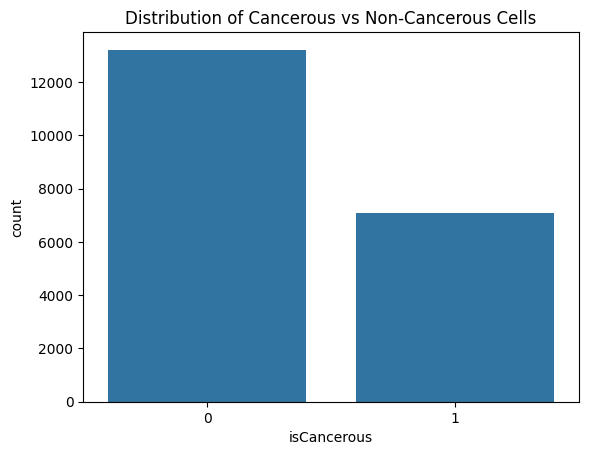

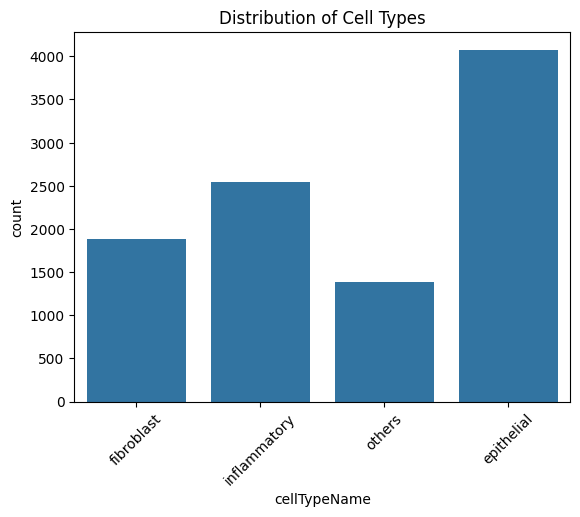

In [14]:
sns.countplot(x='isCancerous', data=dfcancer)
plt.title('Distribution of Cancerous vs Non-Cancerous Cells')
plt.show()

# cellType distribution
sns.countplot(x='cellTypeName', data=df2)
plt.title('Distribution of Cell Types')
plt.xticks(rotation=45)
plt.show()

### Observations
We further explored the overall distribution across both datasets:
1. ***isCancerous Distribution:***
- The bar chart for the isCancerous label shows a noticeable class imbalance.
- The majority of samples are non-cancerous (label 0), accounting for 13211 samples.
- In contrast, cancerous (label 1) samples total just around 7069.

**Implication**: If left unaddressed, this imbalance can cause a binary classifier to be biased toward predicting the majority class (non-cancerous), potentially leading to high accuracy but poor recall for the cancerous class — which is medically critical.

2. ***Cell Type Distribution:***
- The distribution of cellTypeName reveals a moderate class imbalance:
- The epithelial category is the most represented, with more than 4,000 instances.
- In contrast, classes such as others and fibroblast have less than 2,000 samples each.

**Implication**: In a multi-class classification task, this imbalance may lead the model to favor the dominant class (epithelial), while performing poorly on underrepresented categories. This could negatively impact metrics like the macro F1-score and reduce the model's ability to generalize across all classes.

# **Techniques we will use to Handle Class Imbalance**
We plan to apply the following techniques to mitigate the effects of imbalance:
1. Data Augmentation:
We will generate synthetic variations (e.g., rotations, shifts, flips) of minority class images to artificially balance class sizes. This is especially helpful in boosting model generalization without collecting more real-world data.

2. Class Weighting:
During model training, we will assign higher weights to underrepresented classes so that the loss function penalizes misclassification of minority samples more heavily. This improves recall and ensures minority classes receive adequate attention.

Note: These strategies will be implemented after completing the image preprocessing pipeline in the upcoming sections.

# **Data Preprocessing**

### Objective
The goal of preprocessing was to prepare the histopathological images for effective training of a Convolutional Neural Network (CNN) to classify whether a cell image is cancerous and identify its type. Preprocessing included image transformations, normalization, resizing, and preparation of balanced training/testing splits. These steps were critical to improve model generalization, reduce noise, and ensure stable convergence during training.

### Dataset Splitting
To train and evaluate our CNN models effectively, we split each dataset into 80% training and 20% testing subsets. This is a widely adopted convention in machine learning, providing a strong balance between having enough data to train the model and holding out sufficient data to evaluate its generalization performance.

We used stratified sampling to ensure that the class distribution is maintained across both splits. This prevents issues such as class imbalance in the test set, which could distort evaluation metrics.
- dfcancer: Used for binary classification of whether the image shows cancerous cells (isCancerous).
- dfcell: Used for multi-class classification of the cell type (cellType).


In [54]:
traindfcancer, testdfcancer = train_test_split(
    dfcancer, test_size=0.2, random_state=42, stratify=dfcancer['isCancerous']
)
traindfcell, testdfcell = train_test_split(
    dfcell, test_size=0.2, random_state=42, stratify=dfcell['cellType']
)

### Preprocessing Functions
To enhance image clarity and improve model performance, multiple preprocessing techniques were implemented and tested:

1. Grayscale Conversion
Converts the image to a single intensity channel. While grayscale reduces complexity, RGB was retained to preserve potential color-based diagnostic signals.
2. Gaussian Blur
Applies a slight blur to reduce image noise and smoothen textures, which can improve feature learning in CNNs.
3. Simple Threshold Segmentation
Performs binary thresholding on grayscale images to highlight structural regions within the cells. Useful for emphasizing boundaries and shapes.

In [55]:
def to_grayscale(img):
    return Image.fromarray(np.uint8(img)).convert('L').convert('RGB')

def gaussian_blur(img):
    from PIL import ImageFilter
    return Image.fromarray(np.uint8(img)).filter(ImageFilter.GaussianBlur(1))

def simple_threshold_segmentation(img):
    grayscale = Image.fromarray(np.uint8(img)).convert('L')
    threshold = 128
    binary = grayscale.point(lambda p: 255 if p > threshold else 0)
    return binary.convert('RGB')

### Image Loader and Preprocessing

To prepare the images for input into the CNN model, we developed a custom image loading and preprocessing pipeline. This included resizing, applying optional transformations (such as grayscale conversion and Gaussian blur), and normalizing the pixel values.

The original images in the dataset were 27×27 pixels, which are relatively small and limited the CNN’s ability to learn meaningful patterns. To improve performance, all images were resized to 64×64 pixels. This decision was based on empirical results: models trained on 64×64 images consistently outperformed those trained on the original resolution. The increased size retains more spatial detail, allows the model to leverage deeper architectures effectively, and provides a richer signal that improves generalization.

After resizing, pixel values were normalized to the range [0, 1] by dividing by 255. Normalization helps the model train more efficiently by standardizing the input range, which stabilizes gradients and improves compatibility with layers like ReLU and batch normalization. Together, these preprocessing steps enhanced the training stability and overall performance of the CNN.

In [56]:
def load_and_preprocess_images(df, image_dir, preprocessing_fn=None):
    images = []
    for img_name in tqdm(df['ImageName']):
        try:
            img_path = os.path.join(image_dir, img_name)
            img = Image.open(img_path)
            if preprocessing_fn:
                img = preprocessing_fn(img)
            img = img.resize((64, 64))
            img = np.array(img, dtype=np.float32) / 255.0
            images.append(img)
        except Exception as e:
            print(f"Skipped {img_name}: {e}")
            continue
    return np.array(images)

### CNN Model Architecture
To ensure a fair comparison between preprocessing methods, a consistent Convolutional Neural Network (CNN) architecture was used throughout all experiments. The model is designed for binary classification (cancerous vs. non-cancerous) and includes two convolutional layers with ReLU activation, followed by max-pooling layers to reduce spatial dimensions. L2 regularization was applied to convolutional and dense layers to prevent overfitting, and a dropout layer with a rate of 0.6 improves generalization. The final dense layer uses a sigmoid activation function for binary output.

The model balances architectural depth and regularization, supporting meaningful feature extraction while minimizing the risk of overfitting on a relatively small histopathology dataset.

In [ ]:
def create_cancer_cnn(input_shape=(27, 27, 3)):
    l2 = regularizers.l2(0.001)
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2, input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=l2),
        layers.Dropout(0.6),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

### Compilation and Training Procedure
The CNN is compiled using the Adam optimizer (learning rate: 0.0001) and binary cross-entropy loss, with accuracy tracked as the main evaluation metric.

In [ ]:
def compile_cancer_cnn(input_shape=(64, 64, 3), lr=1e-4):
    model = create_cancer_cnn(input_shape=input_shape)
    model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

Data augmentation is applied to the training data to simulate real-world variation. This includes random rotations, shifts, and horizontal flips. It helps reduce overfitting and improves the model's generalization to unseen examples.

To handle class imbalance, class weights were computed using compute_class_weight, ensuring that the model does not become biased toward the more frequent class. Early stopping monitored validation loss and restored the best model weights, preventing overfitting from prolonged training.

In [58]:
def train_model(model, Xtrain, ytrain, Xval, yval):
    augment_gen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    val_gen = ImageDataGenerator()

    train_gen = augment_gen.flow(Xtrain, ytrain, batch_size=32, shuffle=True)
    val_gen_ = val_gen.flow(Xval, yval, batch_size=32, shuffle=False)

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    class_weights = compute_class_weight('balanced', classes=np.unique(ytrain), y=ytrain)
    class_weight_dict = dict(enumerate(class_weights))

    history = model.fit(
        train_gen,
        validation_data=val_gen_,
        epochs=15,
        class_weight=class_weight_dict,
        callbacks=[early_stop],
        verbose=1
    )

    return model, history

### Evaluation Strategy
The model is evaluated using the test set. Accuracy and loss metrics over training epochs are plotted for insight into learning dynamics. This visual inspection helps determine whether the model underfits, overfits, or trains effectively.

In [59]:
def evaluate_model(model, history, Xtest, ytest, label=""):
    val_acc = history.history['val_accuracy'][-1]
    print(f"Final Validation Accuracy with {label}: {val_acc:.4f}")

    # Plot
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - {label}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - {label}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return val_acc

### Comparative Evaluation of Preprocessing Methods
To evaluate the impact of preprocessing, four different approaches were tested: no transformation (baseline), grayscale, Gaussian blur, and threshold segmentation. Each dataset variant was passed through the same CNN architecture and training routine.


--- Testing: baseline ---


100%|██████████| 4056/4056 [00:01<00:00, 2633.70it/s]
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 37s 70ms/step - accuracy: 0.6908 - loss: 0.7789 - val_accuracy: 0.8065 - val_loss: 0.5088
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.8043 - loss: 0.5089 - val_accuracy: 0.8326 - val_loss: 0.4343
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.8158 - loss: 0.4750 - val_accuracy: 0.8572 - val_loss: 0.4043
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - accuracy: 0.8326 - loss: 0.4411 - val_accuracy: 0.8575 - val_loss: 0.4006
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.8319 - loss: 0.4331 - val_accuracy: 0.8681 - val_loss: 0.3631
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.8394 - loss: 0.4229 - val_accuracy: 0.8550 - val_loss: 0.3752
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.8425 - loss: 0.4213 - val_accuracy: 0.8654 - val_loss: 0.3662
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.8369 - loss: 0.4152 - 

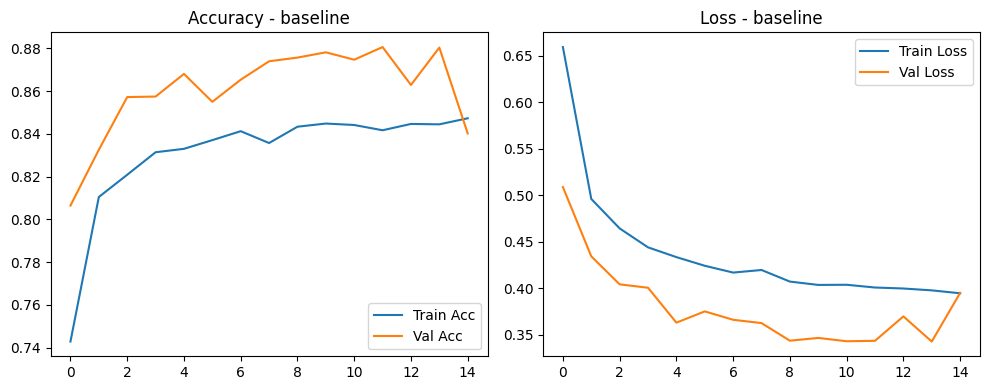


--- Testing: grayscale ---


100%|██████████| 4056/4056 [00:02<00:00, 1939.42it/s]
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 33s 62ms/step - accuracy: 0.5969 - loss: 0.8596 - val_accuracy: 0.8000 - val_loss: 0.6013
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.7180 - loss: 0.6487 - val_accuracy: 0.7495 - val_loss: 0.5765
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.7393 - loss: 0.5945 - val_accuracy: 0.7611 - val_loss: 0.5500
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.7518 - loss: 0.5719 - val_accuracy: 0.7880 - val_loss: 0.5142
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.7527 - loss: 0.5680 - val_accuracy: 0.7845 - val_loss: 0.5162
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.7573 - loss: 0.5520 - val_accuracy: 0.8173 - val_loss: 0.4669
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.7649 - loss: 0.5410 - val_accuracy: 0.8037 - val_loss: 0.4881
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.7708 - loss: 0.5385 - 

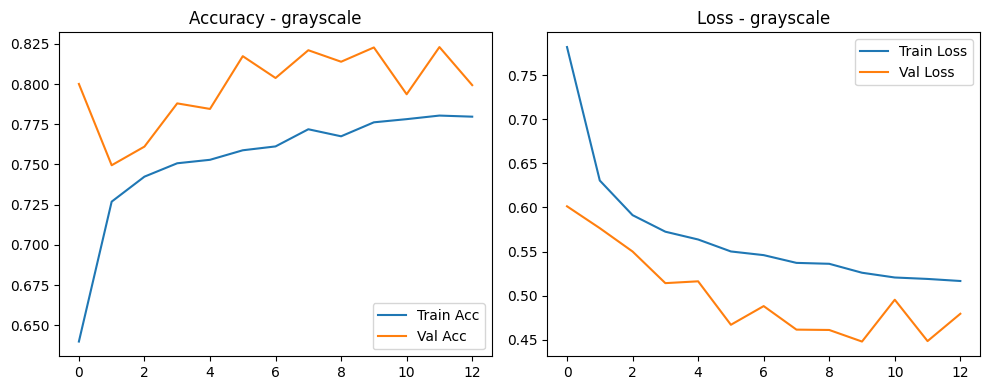


--- Testing: gaussian_blur ---


100%|██████████| 4056/4056 [00:02<00:00, 1931.52it/s]
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 35s 66ms/step - accuracy: 0.6980 - loss: 0.7505 - val_accuracy: 0.7983 - val_loss: 0.5052
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.7974 - loss: 0.5205 - val_accuracy: 0.8417 - val_loss: 0.4102
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.8111 - loss: 0.4863 - val_accuracy: 0.8496 - val_loss: 0.4022
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.8253 - loss: 0.4553 - val_accuracy: 0.8427 - val_loss: 0.4083
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.8282 - loss: 0.4467 - val_accuracy: 0.8227 - val_loss: 0.4445
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.8328 - loss: 0.4354 - val_accuracy: 0.8447 - val_loss: 0.4027
Final Validation Accuracy with gaussian_blur: 0.8447


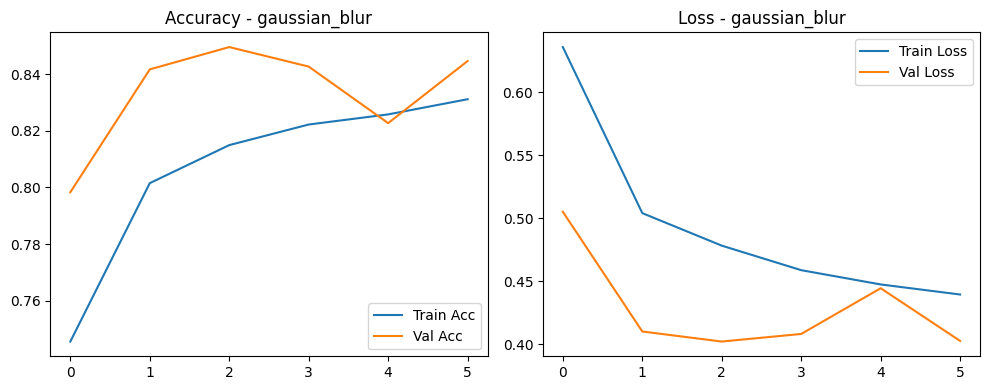


--- Testing: segmentation ---


100%|██████████| 4056/4056 [00:03<00:00, 1264.55it/s]
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 33s 62ms/step - accuracy: 0.6609 - loss: 0.8157 - val_accuracy: 0.7145 - val_loss: 0.6956
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.7410 - loss: 0.6450 - val_accuracy: 0.7964 - val_loss: 0.5472
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.7419 - loss: 0.6202 - val_accuracy: 0.7966 - val_loss: 0.5275
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.7442 - loss: 0.6041 - val_accuracy: 0.7917 - val_loss: 0.5258
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.7509 - loss: 0.5816 - val_accuracy: 0.7867 - val_loss: 0.5267
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.7487 - loss: 0.5789 - val_accuracy: 0.7574 - val_loss: 0.5665
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.7498 - loss: 0.5712 - val_accuracy: 0.7894 - val_loss: 0.5116
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.7659 - loss: 0.5501 - 

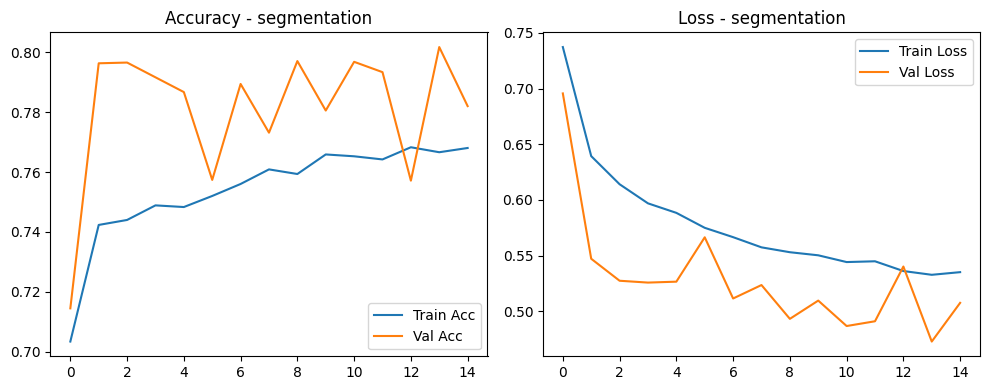


Comparison Results:
baseline: 0.8402
grayscale: 0.7993
gaussian_blur: 0.8447
segmentation: 0.7821


In [60]:
results = {}
histories = {}

preprocessing_methods = {
    'baseline': None,
    'grayscale': to_grayscale,
    'gaussian_blur': gaussian_blur,
    'segmentation': simple_threshold_segmentation
}

for label, preprocessing_fn in preprocessing_methods.items():
    print(f"\n--- Testing: {label} ---")

    # Load and preprocess images
    Xtrain = load_and_preprocess_images(traindfcancer, image_dir, preprocessing_fn)
    Xtest = load_and_preprocess_images(testdfcancer, image_dir, preprocessing_fn)
    ytrain = traindfcancer['isCancerous'].values
    ytest = testdfcancer['isCancerous'].values

    # Create and compile model
    model = compile_cancer_cnn()

    # Train model
    model, history = train_model(model, Xtrain, ytrain, Xtest, ytest)

    # Evaluate model
    val_acc = evaluate_model(model, history, Xtest, ytest, label=label)

    # Store results
    results[label] = val_acc
    histories[label] = history

# Comparison
print("\nComparison Results:")
for key, val in results.items():
    print(f"{key}: {val:.4f}")

Previous layout of preprocessing, model development and evaluation - will delete

In [ ]:
def evaluate_preprocessing(preprocessing_fn, label="No Preprocessing"):
    print(f"\n--- Testing: {label} ---")
    
    def load_images(df):
        images = []
        for img_name in tqdm(df['ImageName']):
            try:
                img_path = os.path.join(image_dir, img_name)
                img = Image.open(img_path)
                if preprocessing_fn:
                    img = preprocessing_fn(img)  # Apply preprocessing before resizing
                img = img.resize((64, 64))
                img = np.array(img, dtype=np.float32) / 255.0
                images.append(img)
            except Exception as e:
                print(f"Skipped {img_name}: {e}")
                continue
        return np.array(images)
    
    Xtrain = load_images(traindfcancer)
    Xtest = load_images(testdfcancer)
    ytrain = traindfcancer['isCancerous'].values
    ytest = testdfcancer['isCancerous'].values

    augment_gen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    val_gen = ImageDataGenerator()

    train_gen = augment_gen.flow(Xtrain, ytrain, batch_size=32, shuffle=True)
    val_gen_ = val_gen.flow(Xtest, ytest, batch_size=32, shuffle=False)

    model = create_cancer_cnn(input_shape=(64, 64, 3))
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    class_weights = compute_class_weight('balanced', classes=np.unique(ytrain), y=ytrain)
    class_weight_dict = dict(enumerate(class_weights))

    history = model.fit(
        train_gen,
        validation_data=val_gen_,
        epochs=15,
        class_weight=class_weight_dict,
        callbacks=[early_stop],
        verbose=1
    )

    val_acc = history.history['val_accuracy'][-1]
    print(f"Final Validation Accuracy with {label}: {val_acc:.4f}")

    plot_history(history, label)
    
    return val_acc, history

def plot_history(history, label=""):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - {label}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - {label}')
    plt.legend()

    plt.tight_layout()
    plt.show()


Must rewrite- Resizing the image from 27x27 to 64x64 does have a slightly better accuracy for the baseline no preprocessing.
- gaussian blur has performed better with the 64x64

### Preprocessing Evaluation Summary
To determine the most effective preprocessing approach for classifying cancerous images, I implemented and evaluated two distinct image preprocessing pipelines. Both approaches involved loading and resizing images, applying optional transformations, and training a convolutional neural network (CNN) to classify cancer presence. The key difference between the two methods lay in the order and detail of preprocessing steps.

The first approach resized all images to 27×27 pixels before applying any preprocessing, with limited augmentation and no performance visualization. The second approach, in contrast, applied preprocessing (such as grayscale conversion, Gaussian blur, and segmentation) before resizing the images to a larger size of 64×64 pixels. This approach also incorporated well-defined data augmentation techniques, early stopping, class balancing, and detailed training visualization (accuracy/loss curves).

Upon testing with multiple preprocessing functions and comparing validation accuracy, the second approach consistently outperformed the first, achieving higher accuracy and more stable training performance. Consequently, the second preprocessing pipeline was selected for the final model due to its superior performance and better adherence to deep learning best practices.

# Model for Binary Classification(isCancerous)

# **Evaluation**

## Model For multi-class cell type classification

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_gen = ImageDataGenerator()

from tensorflow.keras.utils import to_categorical

# One-hot encode labels
ycelltrain_cat = to_categorical(ycelltrain, num_classes=4)
ycelltest_cat = to_categorical(ycelltest, num_classes=4)

# Now generate flows
train_flow = train_gen.flow(Xcelltrain, ycelltrain_cat, batch_size=32, shuffle=True)
val_flow = val_gen.flow(Xcelltest, ycelltest_cat, batch_size=32, shuffle=False)

In [ ]:
from tensorflow.keras import layers, models, regularizers

def create_celltype_cnn(input_shape=(27, 27, 3), num_classes=4):
    l2 = regularizers.l2(0.001)

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2, input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Multi-class

    return model

model2 = create_celltype_cnn()

In [ ]:
from tensorflow.keras.optimizers import Adam

model2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history2 = model2.fit(
    train_flow,
    validation_data=val_flow,
    epochs=30,
    callbacks=[early_stop]
)

In [ ]:
# Get model predictions
y_pred_probs = model2.predict(Xcelltest)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(ycelltest_cat, axis=1)  # True labels

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['fibroblast', 'inflammatory', 'epithelial', 'others'],
            yticklabels=['fibroblast', 'inflammatory', 'epithelial', 'others'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Cell Type Prediction')
plt.tight_layout()
plt.show()

In [ ]:
# Print classification report
print("Classification Report:\n")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=['fibroblast', 'inflammatory', 'epithelial', 'others']
))


⚠️ Key Observations
Class "others" is frequently misclassified, especially as inflammatory and fibroblast.

Confusion matrix shows heavy misclassification of "others" as inflammatory — suggests they share similar features in images.

Macro F1-score is 0.60, pulled down by the poor performance on the "others" class.